## Projeto de IA para o COMPET - Predição de Câncer de Pulmão com IA
Este notebook realiza a análise e modelagem preditiva com base em fatores de risco para doenças pulmonares

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import gradio as gr

# Leitura dos dados
df = pd.read_csv("./dados/lung_cancer_dataset.csv")
df.head()

C:\Users\rrs4_cesar\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,NO
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,YES
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,NO
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,YES
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,YES


In [24]:
# Padronizando a coluna
df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].astype(str).str.strip().str.upper()

# Verificando valores únicos
print(df['PULMONARY_DISEASE'].unique())

#aplicando o mapeamento
df['PULMONARY_DISEASE'] = df['PULMONARY_DISEASE'].map({'NO': 0, 'YES': 1})



['NO' 'YES']


In [25]:
# Reduzindo a quantidade de variáveis para 10
colunas_selecionadas = [
    "SMOKING", "BREATHING_ISSUE", "EXPOSURE_TO_POLLUTION",
    "IMMUNE_WEAKNESS", "ALCOHOL_CONSUMPTION", "FAMILY_HISTORY",
    "SMOKING_FAMILY_HISTORY", "ENERGY_LEVEL", "MENTAL_STRESS", "AGE",
    "PULMONARY_DISEASE"
]

df = df[colunas_selecionadas]


In [26]:
#renomeando as colunas pra fazer mais sentido

df.rename(columns={
    "AGE": "IDADE",
    "SMOKING": "FUMANTE",
    "MENTAL_STRESS": "ESTRESSE",
    "EXPOSURE_TO_POLLUTION": "EXPOSICAO_POLUICAO",
    "ENERGY_LEVEL": "NIVEL_ENERGIA",
    "IMMUNE_WEAKNESS": "SISTEMA_IMUNE_FRACO",
    "BREATHING_ISSUE": "PROBLEMAS_RESPIRATORIOS",
    "ALCOHOL_CONSUMPTION": "CONSUMO_ALCOOL",
    "FAMILY_HISTORY": "HISTORICO_FAMILIAR",
    "SMOKING_FAMILY_HISTORY": "FAMILIA_FUMANTE",
    "PULMONARY_DISEASE": "DOENCA_PULMONAR"
}, inplace=True)


In [27]:
# Confirmar
print(df['DOENCA_PULMONAR'].value_counts())

DOENCA_PULMONAR
0    2963
1    2037
Name: count, dtype: int64


## Análise Exploratória dos Dados

In [28]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FUMANTE                  5000 non-null   int64  
 1   PROBLEMAS_RESPIRATORIOS  5000 non-null   int64  
 2   EXPOSICAO_POLUICAO       5000 non-null   int64  
 3   SISTEMA_IMUNE_FRACO      5000 non-null   int64  
 4   CONSUMO_ALCOOL           5000 non-null   int64  
 5   HISTORICO_FAMILIAR       5000 non-null   int64  
 6   FAMILIA_FUMANTE          5000 non-null   int64  
 7   NIVEL_ENERGIA            5000 non-null   float64
 8   ESTRESSE                 5000 non-null   int64  
 9   IDADE                    5000 non-null   int64  
 10  DOENCA_PULMONAR          5000 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 429.8 KB


,FUMANTE,PROBLEMAS_RESPIRATORIOS,EXPOSICAO_POLUICAO,SISTEMA_IMUNE_FRACO,CONSUMO_ALCOOL,HISTORICO_FAMILIAR,FAMILIA_FUMANTE,NIVEL_ENERGIA,ESTRESSE,IDADE,DOENCA_PULMONAR
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000
mean,0.666400,0.80040,0.516000,0.394800,0.354200,0.301800,0.204000,55.032043,0.539800,57.222800,0.4074
std,0.471546,0.39974,0.499794,0.488857,0.478318,0.459085,0.403009,7.913083,0.498463,15.799224,0.4914
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,23.258308,0.000000,30.000000,0.0000
25%,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,49.440685,0.000000,44.000000,0.0000
50%,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,55.050421,1.000000,57.000000,0.0000
75%,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,60.323320,1.000000,71.000000,1.0000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,83.046971,1.000000,84.000000,1.0000


In [29]:
# Verificar se tem valores nulos
df.isnull().sum()

FUMANTE                    0
PROBLEMAS_RESPIRATORIOS    0
EXPOSICAO_POLUICAO         0
SISTEMA_IMUNE_FRACO        0
CONSUMO_ALCOOL             0
HISTORICO_FAMILIAR         0
FAMILIA_FUMANTE            0
NIVEL_ENERGIA              0
ESTRESSE                   0
IDADE                      0
DOENCA_PULMONAR            0
dtype: int64

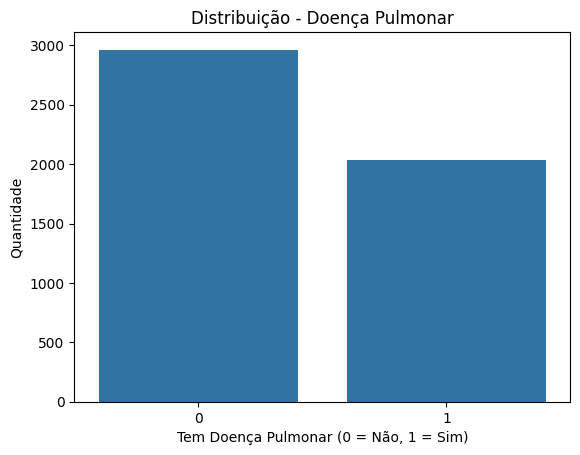

In [30]:
# Distribuição da variável alvo
sns.countplot(data=df, x='DOENCA_PULMONAR')
plt.title('Distribuição - Doença Pulmonar')
plt.xlabel('Tem Doença Pulmonar (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade')
plt.show()

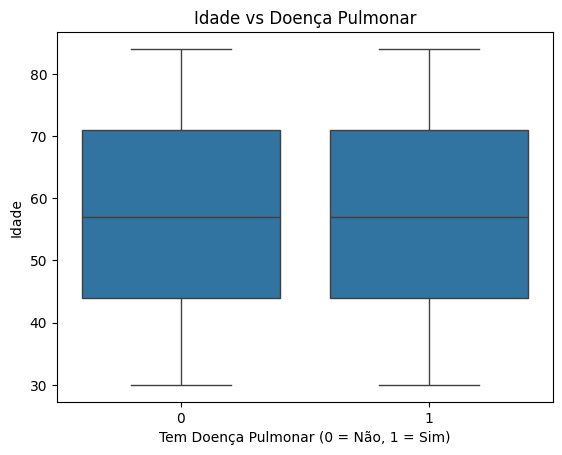

In [31]:
# Gráfico: Idade x Doença Pulmonar
sns.boxplot(data=df, x='DOENCA_PULMONAR', y='IDADE')
plt.title('Idade vs Doença Pulmonar')
plt.xlabel('Tem Doença Pulmonar (0 = Não, 1 = Sim)')
plt.ylabel('Idade')
plt.show()

## Pré-processamento dos Dados

In [32]:
# Separar variáveis preditoras e alvo
X = df.drop('DOENCA_PULMONAR', axis=1)
y = df['DOENCA_PULMONAR']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Treinamento de Modelos de Classificação

In [33]:
# Modelo 1: Regressão Logística
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Acurácia - Regressão Logística:", acc_lr)

Acurácia - Regressão Logística: 0.787


In [37]:
# Modelo 2: Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia - Random Forest:", acc_rf)

Acurácia - Random Forest: 0.807


### Comparativo de Acurácia dos modelos

In [38]:
print(f"Acurácia - Regressão Logística: {acc_lr:.4f}")
print(f"Acurácia - Random Forest: {acc_rf:.4f}")

melhor_modelo = "Random Forest" if acc_rf > acc_lr else "Regressão Logística"
print(f"Melhor modelo: {melhor_modelo}")


Acurácia - Regressão Logística: 0.7870
Acurácia - Random Forest: 0.8070
Melhor modelo: Random Forest


In [14]:
#exportando o arquivo transformado

dados_transformados = pd.concat([X, y], axis=1)
dados_transformados.to_csv("./dados/lung_cancer_transformados.csv", index=False)

## Nível II da atividade – Avaliação melhorada


In [39]:
X = df.drop('DOENCA_PULMONAR', axis=1)
y = df['DOENCA_PULMONAR']

acc_log = []
acc_rf = []

In [40]:
#treinamento com as 30 execuções
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Modelo 1: usando o logistc regression
    model_log = LogisticRegression(max_iter=1000)
    model_log.fit(X_train, y_train)
    y_pred_log = model_log.predict(X_test)
    acc_log.append(accuracy_score(y_test, y_pred_log))

    # Modelo 2: usando o random forest
    model_rf = RandomForestClassifier()
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, y_pred_rf))


In [41]:
# Avaliando os resultados
media_log = np.mean(acc_log)
std_log = np.std(acc_log)
media_rf = np.mean(acc_rf)
std_rf = np.std(acc_rf)

print(f"Regressão Logística - Média: {media_log:.4f}, Desvio Padrão: {std_log:.4f}")
print(f"Floresta Aleatória - Média: {media_rf:.4f}, Desvio Padrão: {std_rf:.4f}")


Regressão Logística - Média: 0.7988, Desvio Padrão: 0.0093
Floresta Aleatória - Média: 0.7945, Desvio Padrão: 0.0101


In [42]:
# Escolher o melhor modelo
melhor_modelo = model_log if media_log >= media_rf else model_rf
melhor_modelo


LogisticRegression(max_iter=1000)

In [45]:
# Salvando com pickle
with open('modelo_melhor.pkl', 'wb') as f:
    pickle.dump(melhor_modelo, f)

print("Modelo de melhor desempenho salvo com sucesso!")

Modelo de melhor desempenho salvo com sucesso!


In [47]:
# Função de predição

with open('modelo_melhor.pkl', 'rb') as f:
    modelo = pickle.load(f)
    
def prever(fumante, prob_resp, poluicao, imune_fraco, alcool, historico, familia_fumante,
           energia, estresse, idade):

    entrada = np.array([[fumante, prob_resp, poluicao, imune_fraco, alcool,
                         historico, familia_fumante, energia, estresse, idade]])
    
    pred = modelo.predict(entrada)[0]
    return f"Risco de câncer de pulmão: {'SIM' if pred == 1 else 'NÃO'}"

In [48]:
#interface do gradio (finalmente um front prof!!!)

interface = gr.Interface(
    fn=prever,
    inputs=[
        gr.Radio([0, 1], label="Fumante (1=Sim, 0=Não)"),
        gr.Radio([0, 1], label="Problemas Respiratórios"),
        gr.Radio([0, 1], label="Exposição à Poluição"),
        gr.Radio([0, 1], label="Sistema Imune Fraco"),
        gr.Radio([0, 1], label="Consome Álcool"),
        gr.Radio([0, 1], label="Histórico Familiar"),
        gr.Radio([0, 1], label="Família Fumante"),
        gr.Number(label="Nível de Energia"),
        gr.Radio([0, 1], label="Estresse"),
        gr.Number(label="Idade"),
    ],
    outputs="text",
    title="Predição de Câncer de Pulmão"
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


C:\Users\rrs4_cesar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Created dataset file at: .gradio\flagged\dataset1.csv
